In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from pylab import cm

import os
import sys
import re
import sympy

import cmath
import matplotlib.patches as patches
from matplotlib import colors as m2colors

import plotly.graph_objects as go

from MMfxns import *

cwd = os.getcwd()
sns.set(style="ticks", font_scale=1.5)

mcolors = dict(m2colors.BASE_COLORS, **m2colors.CSS4_COLORS)

saveall = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 0, 'x')

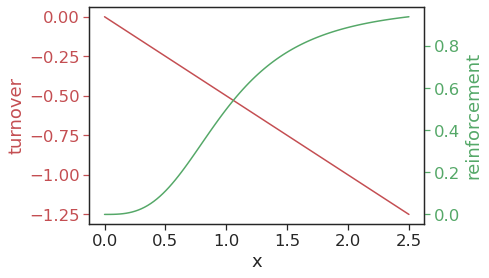

In [178]:
## SI Figure 1
### plot the turnover and self reinforcement terms here w.r.t. x

res = 100
tau = 2
alpha = 1.
n = 3
x_space = np.linspace(0,2.5,res)
turnover = -x_space/tau
reinforce = alpha * x_space ** n / (x_space **n + 1)


fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(x_space, turnover, color='r')
ax.set_ylabel('turnover')
ax.yaxis.label.set_color('r')
ax.tick_params(axis='y', colors='r')

ax2.plot(x_space, reinforce, color='g')
ax2.set_ylabel('reinforcement')
ax2.yaxis.label.set_color('g')
ax2.tick_params(axis='y', colors='g')
# ax2.spines['right']
ax.set_xlabel('x')

In [ ]:
## SI fig 2?

from scipy.signal import argrelextrema

res = 500
m_space = np.linspace(.1, 1.2, res)
a_space = np.linspace(0.5, 1.5, int(res/1))
x_space = np.linspace(0, 3, res)

m0 = 1.
tau = 1.

x_c = x_crit(n)
a_c = alpha_crit(n, tau)
m_c = m_crit_over_m0(n, tau)

print('a_c = %f, x_c = %f, m_c = %f' % (a_c, x_c, m_c))

Uma = np.zeros((len(m_space),len(a_space)))
nummins = np.zeros((len(m_space),len(a_space)))

x_guess = np.linspace(np.amin(x_space), np.amax(x_space), 15)

for ai, aa in enumerate(a_space):
    for mi, mm in enumerate(m_space):
        xoutlist = []
        for xi, xx in enumerate(x_guess):
            
            xout = scipy.optimize.fsolve(x_equil, xx, args=(mm, m0, tau, aa, 3), xtol=1e-10)[0]
            xout = np.round(xout, 6)
            xoutlist.append(xout)
        
        xoutlist = np.unique(xoutlist)    
        x_stiff = 1-np.exp(-mm/m0)
        Uma[mi,ai] = U(x_stiff, xoutlist, aa, tau, 3)
  
print(Uma)
# lenmins = []
# for ai, aa in enumerate(a_space):
#     for mi, mm in enumerate(m_space):
#         Uvec = U(x_stiff, x_space, aa, tau, 3)
#         mins = Uvec[argrelextrema(np.diff(Uvec), np.less)[0]]
#         if len(mins) not in lenmins:
#             lenmins.append(len(mins))

# print(lenmins)
#         nummins[mi,ai]
mm, aa = np.meshgrid(m_space,a_space)
        
fig, ax = plt.subplots(1,1,figsize=(6,6))

cf = ax.contourf(aa, mm, Uma, levels=100, cmap=cm.hot)
cb = plt.colorbar(cf, ax=ax, format='%.2f')
ax.scatter(a_c, m_c)

In [ ]:

a_space = np.linspace(0,2,100)

m1list = [m1n3(ai, 3) for ai in a_space]
m2list = [m2n3(ai, 3) for ai in a_space]
# plt.plot(a_space, m1list)
# plt.plot(a_space, m2list)

plt.plot(np.arange(len(deltaVlist)), deltaVlist)
plt.show()